### Working
### 2 class 
### accuracy = 83% +

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import pandas as pd
from PIL import Image
import numpy as np
import torchvision.models as models

import os

import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import random
import random
import torchvision
from torch.utils.data import ConcatDataset


torch.manual_seed(42)

    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [2]:
# get_malignancy gets the malignancy as a tensor

def get_malignancy(lidc_df, nodule_id, binary, device=device):
    malignancy = lidc_df[lidc_df['noduleID'] == nodule_id]['Malignancy'].iloc[0]
    if binary:
        return torch.tensor(1, device=device) if malignancy > 1 else torch.tensor(0)

    return torch.tensor(malignancy) if malignancy > 1 else torch.tensor(malignancy)

# Normalise images

def get_normed(this_array, this_min=0, this_max=255, set_to_int=True):
    """
        INPUTS:
        this_array: raw image from file

        OUTPUT:
        normalized version of image
    """
    rat = (this_max - this_min) / (this_array.max() - this_array.min())
    this_array = this_array * rat
    this_array -= this_array.min()
    this_array += this_min
    if set_to_int:
        return this_array.to(dtype=torch.int) / this_max
    return this_array / this_max

#images to df

def images_to_df(image_folder='C:/Users/SMADARAP/Downloads/LIDC dataset_extracted_CNNfeatures/data/LIDC(MaxSlices)_Nodules',
                 image_labels='C:/Users/SMADARAP/Downloads/LIDC dataset_extracted_CNNfeatures/data/LIDC_newMode_2022.csv',
                 image_dim=71):
    
    # set folder and where to get labels for each image
    #image dim == 71 == manually set bc some guy said the max size of the nodule found == 71
    
    '''
    Creates a dataframe of noduleID and corresponding image tensor

    inputs:
    image_folder: the folder of images
    image_labels: path of csv file containing labels
    image_dim: the dimension of image

    output:
    img_df: pandas dataframe of noduleID and corresponding image as a numpy tensor

    '''
    LIDC_labels = pd.read_csv(image_labels, index_col=0)
    # scalar = scale_image(image_dim)
    cols = {'noduleID': [], 'malignancy': [], 'image': []}
  

    for file in os.listdir(image_folder):
        nodule_id = int(file.split('.')[0])
        malignancy = get_malignancy(LIDC_labels, nodule_id, False)
        
        # get the malignancy tensor as a number
        malignancy_int = malignancy.item()
        
        # this if statement is to omit adding rows to our data structure that have a rating of 3 (because it is indeterminate)
        if malignancy_int != 3:
   
            image_raw = np.loadtxt(os.path.join(image_folder, file))
            image_raw = torch.from_numpy(image_raw)
            image_normed = get_normed(image_raw).unsqueeze(dim=0)
            # image = scalar(image_normed)

            cols['noduleID'].append(nodule_id)
            cols['malignancy'].append(malignancy)
            cols['image'].append(image_normed)


    img_df = pd.DataFrame(cols)
    img_df.sort_values('noduleID', inplace=True)
    img_df.reset_index(drop=True, inplace=True)

    return img_df


LIDC_raw_data = images_to_df()

noduleID = LIDC_raw_data['noduleID'].values
malignancy = LIDC_raw_data['malignancy'].values
images = LIDC_raw_data['image'].values

malignancy = torch.tensor([x.item() for x in malignancy])
image_list = [image.clone().detach() for image in images]
images_input = torch.stack(image_list)


In [3]:
class YourDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]


class ModifiedDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __getitem__(self, index):
        image, label = self.original_dataset[index]
        if label == 1:
            modified_label = 0
        elif label == 2:
            modified_label = 0
        elif label == 4:
            modified_label = 1
        elif label == 5:
            modified_label = 1
        else:
            modified_label = label  
        return image, modified_label

    def __len__(self):
        return len(self.original_dataset)


def get_augmentation_transforms(reference_paper):
    transformatio=[]
    
    #flip
    horizontal_flip = transforms.RandomHorizontalFlip(p=1)
    vertical_flip = transforms.RandomVerticalFlip(p=1)
    
    #rotation
    random_rotation = transforms.RandomRotation(degrees=(-20, 20))
    rotation_30_degrees = transforms.RandomRotation(degrees=30)
    rotation_60_degrees = transforms.RandomRotation(degrees=60)
    rotation_90_degrees = transforms.RandomRotation(degrees=90)
    rotation_180_degrees = transforms.RandomRotation(degrees=180)
    rotation_270_degrees = transforms.RandomRotation(degrees=270)
    
    #random_noise
    random_noise = transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x))
    
    # Contrast adjustment
    contrast = transforms.ColorJitter(contrast=(0.5, 1.5))
    
    # random_erase
    random_erase = transforms.RandomErasing(p=1, scale=(0.02, 0.10), ratio=(0.3, 3.3))



    # Shear transformations
    shear_x = transforms.RandomAffine(degrees=0, shear=(-0.3, 0.3))
    shear_y = transforms.RandomAffine(degrees=0, shear=(-0.3, 0.3))


    # Translate transformations
    translate_x = transforms.RandomAffine(degrees=0, translate=(0.1, 0))
    translate_y = transforms.RandomAffine(degrees=0, translate=(0, 0.1))
    

    # Invert colors
    invert = transforms.Lambda(lambda x: 1 - x)

    # Equalize histogram
    equalize = transforms.Lambda(lambda x: transforms.functional.equalize(x))

    # Solarize
    solarize = transforms.Compose([transforms.RandomSolarize(threshold=0.5)])

    # Posterize
    posterize = transforms.RandomPosterize(bits=(4, 8))

    # Sharpening
    sharpen = transforms.Lambda(lambda x: transforms.functional.adjust_sharpness(x, 2.0))

    # Zoom In
    zoom_in = transforms.RandomAffine(degrees=0, scale=(1.0, 1.2))

    # Zoom Out
    zoom_out = transforms.RandomAffine(degrees=0, scale=(0.8, 1.0))
    
    if reference_paper==0:
        return 0
    elif reference_paper==1:
        transformatio = [horizontal_flip,
                         zoom_in,zoom_out,
                         rotation_90_degrees,
                         rotation_180_degrees,
                         rotation_270_degrees]
    elif reference_paper==2:
        transformatio = [horizontal_flip,
                         vertical_flip,
                         random_rotation, rotation_30_degrees, rotation_60_degrees,rotation_90_degrees, rotation_180_degrees,rotation_270_degrees,
                         random_noise]
    elif reference_paper==3:
        transformatio = [horizontal_flip,
                         vertical_flip,
                         random_rotation,rotation_30_degrees,rotation_60_degrees,rotation_90_degrees,rotation_270_degrees,
                         random_noise,
                         contrast,
                         random_erase,
                         shear_x,shear_y,
                         translate_x,translate_y,
                         invert,
                         solarize,
                         sharpen,
                         zoom_in,zoom_out]
        

    return transformatio
    
def augment_and_combine_datasets(train_dataset, transformations):
    
    print(f"No. of transformations: {len(transformations)}")
    augmented_data = []
    original_loader = train_dataset

    for transformation in transformations:
        for image, label in original_loader:
            augmented_image = transformation(image)
            augmented_data.append((augmented_image, label))

    combined_dataset = ConcatDataset([train_dataset,augmented_data])

    return combined_dataset



In [4]:

x_train, x_temp, y_train, y_temp = train_test_split(images_input, malignancy, test_size=0.3, random_state=42, shuffle=True, stratify=malignancy)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle=True, stratify=y_temp)



train_dataset = YourDataset(x_train, y_train)
val_dataset = YourDataset(x_val, y_val)
test_dataset = YourDataset(x_test, y_test)

print("Size of train_dataset:", len(train_dataset))
print("Size of val_dataset:", len(val_dataset))
print("Size of test_dataset:", len(test_dataset))


#transformations
transformations_1 = get_augmentation_transforms(1)
transformations_2 = get_augmentation_transforms(2)
transformations_3 = get_augmentation_transforms(3)

#generate aug from train data and combine
combined_dataset_1 = augment_and_combine_datasets(train_dataset, transformations_1)
combined_dataset_2 = augment_and_combine_datasets(train_dataset, transformations_2)
combined_dataset_3 = augment_and_combine_datasets(train_dataset, transformations_3)



# Create a new dataset with modified labels
modified_train_dataset_0 = ModifiedDataset(train_dataset)
modified_train_dataset_1 = ModifiedDataset(combined_dataset_1)
modified_train_dataset_2 = ModifiedDataset(combined_dataset_2)
modified_train_dataset_3 = ModifiedDataset(combined_dataset_3)

modified_val_dataset = ModifiedDataset(val_dataset)
modified_test_dataset = ModifiedDataset(test_dataset)


batch_size = 128

train_loader_0 = DataLoader(modified_train_dataset_0, batch_size, shuffle=True)
train_loader_1 = DataLoader(modified_train_dataset_1, batch_size, shuffle=True)
train_loader_2 = DataLoader(modified_train_dataset_2, batch_size, shuffle=True)
train_loader_3 = DataLoader(modified_train_dataset_3, batch_size, shuffle=True)

val_loader = DataLoader(modified_val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(modified_test_dataset, batch_size, shuffle=False)

Size of train_dataset: 1041
Size of val_dataset: 223
Size of test_dataset: 224
No. of transformations: 6
No. of transformations: 9
No. of transformations: 19


In [5]:
def create_model(num_classes):
    model = ResNetModel(num_classes)
    return model.to(device)

class ResNetModel(nn.Module):
    def __init__(self, num_classes):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(weights=None)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)



def train(model, train_dataloader, val_dataloader, num_epochs, criterion, optimizer,scheduler):
    model.to(device)
    
    for epoch in range(num_epochs):
        # Training phase
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        model.train()
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_loss = running_loss / len(train_dataloader)
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        
        #parameter = next(model.parameters())
        #print(parameter.device)
    
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_loss /= len(val_dataloader)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)
        
        scheduler.step(val_accuracy)
        
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.2f}%")


def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')


In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
num_classes = 2

model = create_model(num_classes)
criterion = nn.CrossEntropyLoss()
learning_rates = []
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

num_epochs=40
learning_rate=0.01
weight_decay=5e-4
optimizer = optim.Adam(model.parameters(), lr = learning_rate,weight_decay=weight_decay)
#optimizer = optim.SGD(model.parameters(), lr = learning_rate,momentum=0.5, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=2, verbose=False)

train(model, train_loader_0, val_loader, num_epochs=num_epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
test(model, test_loader)

Epoch 1/40 | Train Loss: 1.3286 | Train Accuracy: 55.81% | Validation Loss: 236.3363 | Validation Accuracy: 60.09%
Epoch 2/40 | Train Loss: 0.7829 | Train Accuracy: 57.54% | Validation Loss: 8.9663 | Validation Accuracy: 60.54%
Epoch 3/40 | Train Loss: 0.6512 | Train Accuracy: 63.40% | Validation Loss: 12.2924 | Validation Accuracy: 60.99%
Epoch 4/40 | Train Loss: 0.6587 | Train Accuracy: 62.44% | Validation Loss: 3.3213 | Validation Accuracy: 60.54%
Epoch 5/40 | Train Loss: 0.6415 | Train Accuracy: 70.70% | Validation Loss: 0.9149 | Validation Accuracy: 47.53%
Epoch 6/40 | Train Loss: 0.6216 | Train Accuracy: 69.84% | Validation Loss: 0.5952 | Validation Accuracy: 70.40%
Epoch 7/40 | Train Loss: 0.4910 | Train Accuracy: 77.62% | Validation Loss: 0.5876 | Validation Accuracy: 68.61%
Epoch 8/40 | Train Loss: 0.4197 | Train Accuracy: 81.56% | Validation Loss: 0.4091 | Validation Accuracy: 85.65%
Epoch 9/40 | Train Loss: 0.4124 | Train Accuracy: 83.09% | Validation Loss: 0.5059 | Validati

In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
num_classes = 2

model = create_model(num_classes)
criterion = nn.CrossEntropyLoss()
learning_rates = []
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

num_epochs=40
learning_rate=0.01
weight_decay=5e-4
optimizer = optim.Adam(model.parameters(), lr = learning_rate,weight_decay=weight_decay)
#optimizer = optim.SGD(model.parameters(), lr = learning_rate,momentum=0.5, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=2, verbose=False)

train(model, train_loader_1, val_loader, num_epochs=num_epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
test(model, test_loader)

Epoch 1/40 | Train Loss: 0.7843 | Train Accuracy: 64.77% | Validation Loss: 0.4911 | Validation Accuracy: 78.03%
Epoch 2/40 | Train Loss: 0.4306 | Train Accuracy: 82.35% | Validation Loss: 0.4459 | Validation Accuracy: 78.48%
Epoch 3/40 | Train Loss: 0.3593 | Train Accuracy: 85.00% | Validation Loss: 0.4117 | Validation Accuracy: 79.37%
Epoch 4/40 | Train Loss: 0.3561 | Train Accuracy: 84.75% | Validation Loss: 0.4263 | Validation Accuracy: 86.10%
Epoch 5/40 | Train Loss: 0.3499 | Train Accuracy: 84.86% | Validation Loss: 0.5728 | Validation Accuracy: 78.48%
Epoch 6/40 | Train Loss: 0.3430 | Train Accuracy: 85.78% | Validation Loss: 0.3555 | Validation Accuracy: 84.75%
Epoch 7/40 | Train Loss: 0.3298 | Train Accuracy: 85.40% | Validation Loss: 0.3720 | Validation Accuracy: 82.96%
Epoch 8/40 | Train Loss: 0.3205 | Train Accuracy: 86.61% | Validation Loss: 0.3389 | Validation Accuracy: 87.89%
Epoch 9/40 | Train Loss: 0.3169 | Train Accuracy: 86.72% | Validation Loss: 0.3231 | Validation 

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
num_classes = 2

model = create_model(num_classes)
criterion = nn.CrossEntropyLoss()
learning_rates = []
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

num_epochs=40
learning_rate=0.01
weight_decay=5e-4
optimizer = optim.Adam(model.parameters(), lr = learning_rate,weight_decay=weight_decay)
#optimizer = optim.SGD(model.parameters(), lr = learning_rate,momentum=0.5, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=2, verbose=False)

train(model, train_loader_2, val_loader, num_epochs=num_epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
test(model, test_loader)

Epoch 1/40 | Train Loss: 0.6996 | Train Accuracy: 68.17% | Validation Loss: 0.5039 | Validation Accuracy: 73.99%
Epoch 2/40 | Train Loss: 0.4049 | Train Accuracy: 84.46% | Validation Loss: 0.3979 | Validation Accuracy: 84.75%
Epoch 3/40 | Train Loss: 0.3575 | Train Accuracy: 85.37% | Validation Loss: 0.3390 | Validation Accuracy: 87.44%
Epoch 4/40 | Train Loss: 0.3301 | Train Accuracy: 86.48% | Validation Loss: 0.3523 | Validation Accuracy: 86.55%
Epoch 5/40 | Train Loss: 0.3216 | Train Accuracy: 86.64% | Validation Loss: 0.3790 | Validation Accuracy: 84.75%
Epoch 6/40 | Train Loss: 0.3139 | Train Accuracy: 87.48% | Validation Loss: 0.3487 | Validation Accuracy: 84.75%
Epoch 7/40 | Train Loss: 0.2914 | Train Accuracy: 88.24% | Validation Loss: 0.3354 | Validation Accuracy: 86.55%
Epoch 8/40 | Train Loss: 0.2935 | Train Accuracy: 87.94% | Validation Loss: 0.3480 | Validation Accuracy: 85.65%
Epoch 9/40 | Train Loss: 0.2820 | Train Accuracy: 88.07% | Validation Loss: 0.3941 | Validation 

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
num_classes = 2

model = create_model(num_classes)
criterion = nn.CrossEntropyLoss()
learning_rates = []
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

num_epochs=40
learning_rate=0.01
weight_decay=5e-4
optimizer = optim.Adam(model.parameters(), lr = learning_rate,weight_decay=weight_decay)
#optimizer = optim.SGD(model.parameters(), lr = learning_rate,momentum=0.5, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=2, verbose=False)

train(model, train_loader_3, val_loader, num_epochs=num_epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
test(model, test_loader)

Epoch 1/40 | Train Loss: 0.6031 | Train Accuracy: 74.72% | Validation Loss: 0.5046 | Validation Accuracy: 80.27%
Epoch 2/40 | Train Loss: 0.3506 | Train Accuracy: 84.94% | Validation Loss: 0.3905 | Validation Accuracy: 83.86%
Epoch 3/40 | Train Loss: 0.3253 | Train Accuracy: 86.28% | Validation Loss: 0.3791 | Validation Accuracy: 85.20%
Epoch 4/40 | Train Loss: 0.3048 | Train Accuracy: 87.30% | Validation Loss: 0.4246 | Validation Accuracy: 82.96%
Epoch 5/40 | Train Loss: 0.2892 | Train Accuracy: 87.85% | Validation Loss: 0.3149 | Validation Accuracy: 87.89%
Epoch 6/40 | Train Loss: 0.2733 | Train Accuracy: 88.81% | Validation Loss: 0.3627 | Validation Accuracy: 84.75%
Epoch 7/40 | Train Loss: 0.2630 | Train Accuracy: 89.41% | Validation Loss: 0.3484 | Validation Accuracy: 84.75%
Epoch 8/40 | Train Loss: 0.2506 | Train Accuracy: 90.12% | Validation Loss: 0.4187 | Validation Accuracy: 81.17%
Epoch 9/40 | Train Loss: 0.2301 | Train Accuracy: 91.12% | Validation Loss: 0.3573 | Validation 

In [ ]:
#Parameters for 4 class resnet18
num_epochs=50
learning_rate=0.001 / 0.005
weight_decay=5e-4 / 1e-4
optimizer = optim.SGD(model.parameters(), lr = learning_rate,momentum=0.5, weight_decay=weight_decay)

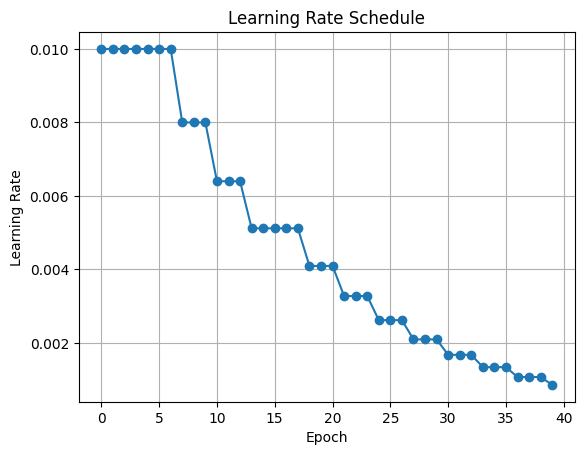

In [10]:
plt.plot(range(num_epochs), learning_rates, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()

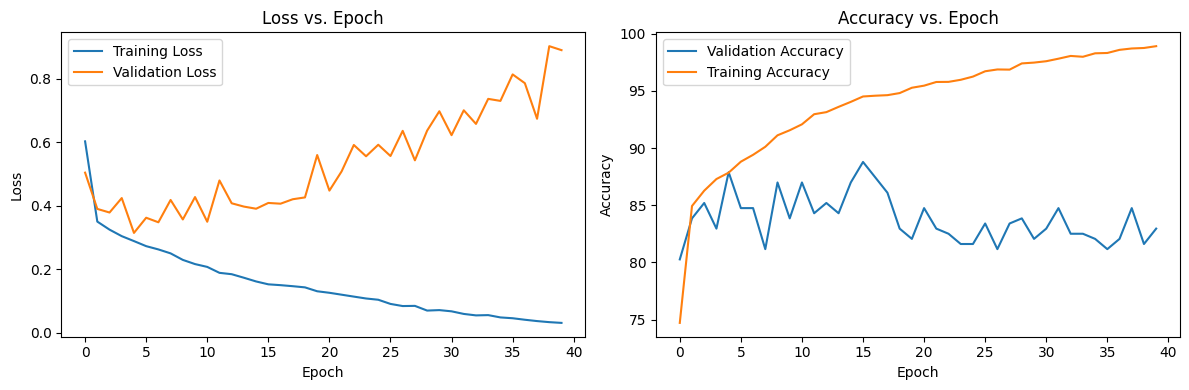

In [11]:
# Create plots for accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs. Epoch")

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy_history, label="Validation Accuracy")
plt.plot(train_accuracy_history, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs. Epoch")

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
import torch

def save_images_with_rating(images_input, malignancy_rating, noduleID, output_dir):
    # Make sure the output directory exists
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    for i in range(len(images_input)):
        image = images_input[i].squeeze().numpy()  # Remove the single channel dimension
        rating = malignancy_rating[i].item()

        # Normalize the image to the uint8 range [0, 255]
        image_normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

        # Save the normalized image with the rating overlaid
        output_filename = f"{output_dir}/{rating}_rat_image_{i}.jpg"
        cv2.imwrite(output_filename, image_normalized)


# Example usage:
if __name__ == "__main__":
    output_directory = 'output_images'
    save_images_with_rating(images_input, malignancy, noduleID, output_directory)


In [ ]:
def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)

#save_model(model, save_path)